# Neural Network from scratch with NumPy - Coffee Roasting Example

## Introduction

In this notebook, I’ll  build a simple neural network from scratch using only NumPy. The example is based on a fun (and real!) dataset: coffee roasting, with features being temperature and roasting duration. The goal: predict if a roast is good (1) or bad (0).

### Import the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

I implement a helper function load_coffee_data() that generates a synthetic dataset of coffee roast conditions (temperature and duration) and assigns binary labels indicating whether each sample represents a "good roast" (1) or "waste" (0). Here's how the function works:

In [4]:
def load_coffee_data():
    # Set up a random number generator with a fixed seed for reproducibility
    rng = np.random.default_rng(2)
    # Generate 400 uniform random values and reshape into N x 2 array: [temperature, duration]
    X = rng.random(400).reshape(-1, 2)
    # Scale the duration feature to range [11.5, 15.5] minutes
    X[:, 1] = X[:, 1] * 4 + 11.5
    # Scale the temperature feature to range [150, 285] °C
    X[:, 0] = X[:, 0] * (285 - 150) + 150
    # Initialize labels array
    Y = np.zeros(len(X))

    # Assign labels based on roast criteria
    for i, (t, d) in enumerate(X):
        # Define a linear boundary y_max = -3/(260-175)*t + 21 for maximum duration at a given temperature
        y_max = -3 / (260 - 175) * t + 21
        # Label as 1 ("good roast") if within temperature and duration bounds and under the boundary
        if 175 < t < 260 and 12 < d < 15 and d <= y_max:
            Y[i] = 1
        else:
            Y[i] = 0

    # Return features X and labels Y as column vector
    return X, Y.reshape(-1, 1)

In [5]:
X, Y = load_coffee_data()
print(X.shape, Y.shape)

(200, 2) (200, 1)


In this section we define a helper function to plot our coffee‐roasting dataset, showing which combinations of temperature and duration produce a “good” roast versus a “bad” one. The plot also overlays the heuristic boundaries used to classify roasts (a sloped line, a horizontal line at 12 min, and a vertical line at 175 °C). This gives us an immediate visual sense of how well our model—or simple rule—matches the data.

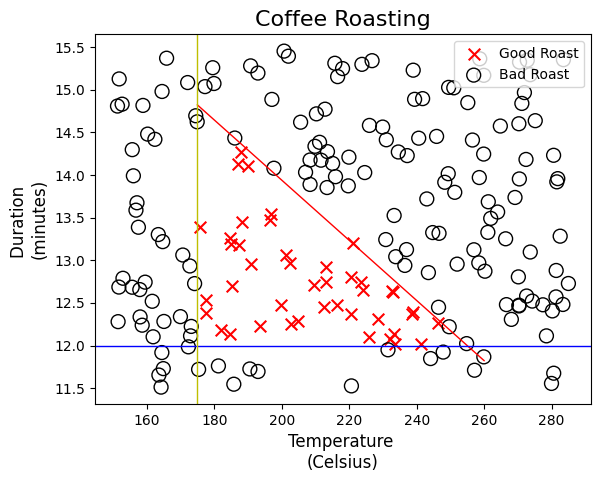

In [6]:
def plt_roast(X, Y):
    Y = Y.reshape(-1,)
    # Define colors for clarity (not used directly in scatter but kept for reference)
    colormap = np.array(["r", "b"])

    # Create a figure and a single subplot
    fig, ax = plt.subplots(1, 1)

    # Plot points classified as “good roast” (Y == 1) in red X’s
    ax.scatter(
        X[Y == 1, 0],     
        X[Y == 1, 1],      
        s=70,               
        marker="x",      
        c="red",         
        label="Good Roast" 
    )

    # Plot points classified as “bad roast” (Y == 0) as hollow circles
    ax.scatter(
        X[Y == 0, 0],             
        X[Y == 0, 1],        
        s=100,                
        marker="o",           
        facecolors="none",  
        linewidth=1,                 
        edgecolors="black",       
        label="Bad Roast"              
    )

    # Plot the sloped boundary line: duration = –3/85 * temp + 21
    tr = np.linspace(175, 260, 50)      
    ax.plot(
        tr,                             
        (-3 / 85) * tr + 21,           
        color="r",                     
        linewidth=1                     
    )

    # Add horizontal rule at duration = 12 minutes
    ax.axhline(y=12, color="b", linewidth=1)

    # Add vertical rule at temperature = 175 °C
    ax.axvline(x=175, color="y", linewidth=1)

    ax.set_title("Coffee Roasting", size=16)
    ax.set_xlabel("Temperature \n(Celsius)", size=12)
    ax.set_ylabel("Duration \n(minutes)", size=12)

    # Display legend in the upper-right corner
    ax.legend(loc="upper right")

    plt.show()

plt_roast(X, Y)

### Normalize Data

In [12]:
# Assume X is your array of shape (n_samples, 2)

# Pre-normalization range
print(f"Temperature Max, Min pre-normalization: {X[:,0].max():0.2f}, {X[:,0].min():0.2f}")
print(f"Duration    Max, Min pre-normalization: {X[:,1].max():0.2f}, {X[:,1].min():0.2f}")

# Compute mean and standard deviation for each column
means = X.mean(axis=0)
stds  = X.std(axis=0)

print(f"Mean (temp, duration): {means[0]:0.2f}, {means[1]:0.2f}")
print(f"Std  (temp, duration): {stds[0]:0.2f}, {stds[1]:0.2f}")

# Normalize: (value - mean) / std for each feature
Xn = (X - means) / stds

# Check post-normalization range
print(f"Temperature Max, Min post normalization: {Xn[:,0].max():0.2f}, {Xn[:,0].min():0.2f}")
print(f"Duration    Max, Min post normalization: {Xn[:,1].max():0.2f}, {Xn[:,1].min():0.2f}")

Temperature Max, Min pre-normalization: 284.99, 151.32
Duration    Max, Min pre-normalization: 15.45, 11.51
Mean (temp, duration): 218.67, 13.43
Std  (temp, duration): 39.96, 1.13
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


I’m going to reimplement our “Coffee Roasting Network” in pure NumPy. It has two layers, each using a sigmoid activation. To build a dense layer, I loop over each unit 𝑗, compute 𝑧𝑗 = 𝑥 ⋅ 𝑊[:,𝑗] +𝑏𝑗, apply the sigmoid 𝑔(𝑧𝑗), and collect all outputs into a vector. That gives me the activated output of the layer, ready to feed into the next on

In [50]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [51]:
def my_dense(a_in, W, b, g):
    units = W.shape[1]
    a_out = np.zeros(units)
    for j in range(units):
        w = W[:,j]
        z = np.dot(w, a_in) + b[j]
        a_out[j] = g(z)
    return (a_out)

The following cell builds a two-layer neural network utilizing the my_dense subroutine above.



In [57]:
def my_sequential(x, W1, b1, W2, b2):
    a1 = my_dense(x,  W1, b1, sigmoid)
    a2 = my_dense(a1, W2, b2, sigmoid)
    return a2[0]

In [58]:
W1_tmp = np.array( [[-8.93,  0.29, 12.9 ], [-0.1,  -7.32, 10.81]] )
b1_tmp = np.array( [-9.82, -9.28,  0.96] )
W2_tmp = np.array( [[-31.18], [-27.59], [-32.56]] )
b2_tmp = np.array( [15.41] )

### Predictions

I’ll next add a predict helper—just like model.predict() in TensorFlow—to score a whole batch of examples:

In [59]:
def my_predict(X, W1, b1, W2, b2):
    m = X.shape[0]               # number of examples
    p = np.zeros((m, 1))         # placeholder for probabilities
    for i in range(m):
        # run each example through our two-layer network
        p[i, 0] = my_sequential(X[i], W1, b1, W2, b2)
    return p

We can try this routine on two examples:

In [60]:
x_tst = np.array([
    [200, 13.9],
    [200, 17]
])

# normalize
means = X.mean(axis=0)
stds  = X.std(axis=0)
X_testn = (x_tst - means) / stds


In [63]:
predictions = my_predict(X_testn, W1_tmp, b1_tmp, W2_tmp, b2_tmp)
predictions

array([[9.71930379e-01],
       [3.28978702e-08]])

Then I turn those probabilities into 0/1 decisions with a 0.5 cutoff. Instead of the long loop in the notebook, I’d do it in one line:

In [64]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i]>=0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0

print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]


This can be accomplished more succinctly:



In [65]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


**Network Overview**

These plots illustrate the full network’s behavior, exactly matching our TensorFlow results from the last lab. On the left, you see the raw outputs of the final layer (shaded in blue) laid on top of the original training points (X’s and O’s). On the right, those same outputs have been thresholded into binary decisions—here the X’s and O’s show how the network classifies each point.


In [71]:
def plot_network(X, Y, prob_fn, label_fn, grid_steps=200, pad=1.0):
    # build a regular grid over the feature space
    x_min, x_max = X[:,0].min() - pad, X[:,0].max() + pad
    y_min, y_max = X[:,1].min() - pad, X[:,1].max() + pad
    xx = np.linspace(x_min, x_max, grid_steps)
    yy = np.linspace(y_min, y_max, grid_steps)
    XX, YY = np.meshgrid(xx, yy)
    grid = np.c_[XX.ravel(), YY.ravel()]

    #evaluate probability and label on every grid point
    Z_prob  = prob_fn(grid).reshape(XX.shape)
    Z_label = label_fn(grid).reshape(XX.shape)

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14,5))

    # probability shading + data + decision boundary
    im = ax0.contourf(XX, YY, Z_prob, levels=50, cmap='Blues', vmin=0, vmax=1, alpha=0.8)
    fig.colorbar(im, ax=ax0, label='P(good roast)')
    # raw data
    ax0.scatter(X[Y.flatten()==1,0], X[Y.flatten()==1,1],
                c='red',    marker='x', s=70, label='Good Roast')
    ax0.scatter(X[Y.flatten()==0,0], X[Y.flatten()==0,1],
                facecolors='none', edgecolors='blue',
                marker='o', s=100, label='Bad Roast')
    # boundary lines in purple
    tr = np.linspace(x_min, x_max, 100)
    purple = '#7f007f'
    ax0.plot(tr, -3/85*tr + 21, color=purple, linewidth=1)
    ax0.axhline(12, color=purple, linewidth=1)
    ax0.axvline(175, color=purple, linewidth=1)
    ax0.set_title("network probability")
    ax0.set_xlabel("Temperature (°C)")
    ax0.set_ylabel("Duration (minutes)")
    ax0.legend(loc='upper right')

    # binary decision + predicted Good points
    ax1.contourf(XX, YY, Z_label, levels=[-0.1,0.5,1.1],
                 colors=['white','lightyellow'], alpha=0.3)
    # show predicted goods
    ax1.scatter(X[label_fn(X)==1,0], X[label_fn(X)==1,1],
                c='orange', marker='x', s=70, label='Predicted Good Roast')
    # show all true bads
    ax1.scatter(X[Y.flatten()==0,0], X[Y.flatten()==0,1],
                facecolors='none', edgecolors='blue', marker='o', s=100,
                label='Bad Roast')
    # same boundary lines
    ax1.plot(tr, -3/85*tr + 21, color=purple, linewidth=1)
    ax1.axhline(12, color=purple, linewidth=1)
    ax1.axvline(175, color=purple, linewidth=1)
    ax1.set_title("network decision")
    ax1.set_xlabel("Temperature (°C)")
    ax1.set_ylabel("Duration (minutes)")
    ax1.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

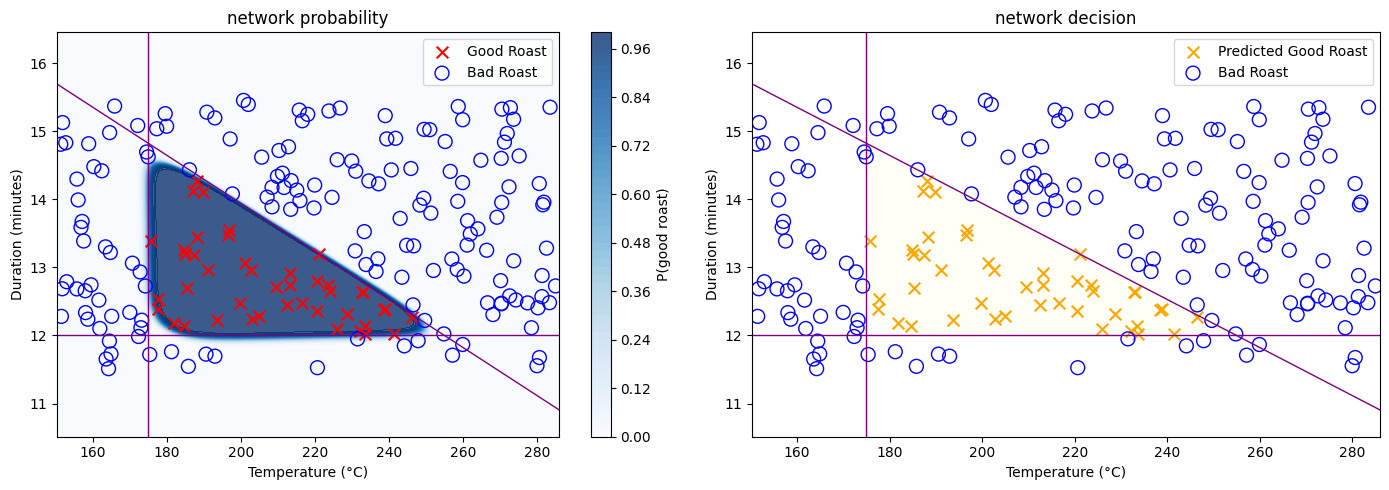

In [72]:
#define prob_fn and label_fn over *raw* (un-normalized) inputs
prob_fn  = lambda pts: my_predict((pts-means)/stds, 
                                  W1_tmp, b1_tmp, W2_tmp, b2_tmp).ravel()
label_fn = lambda pts: (prob_fn(pts) >= 0.5).astype(int)

plot_network(X, Y, prob_fn, label_fn)


**Key Observations**

1. **Probability Map (left panel)**

   * The darkest blue region shows where the network predicts a high probability of a “Good Roast.”
   * That triangular area aligns almost exactly with our synthetic rule $d \le -\tfrac{3}{85}t + 21,\;t>175,\;12<d<15$.
   * Outside that triangle, the probability rapidly drops toward zero.

2. **Binary Decision (right panel)**

   * After thresholding at 0.5, all points inside the triangle become label 1 (orange ×’s), and everything else is 0 (hollow circles).
   * There are no misclassifications on the training set: the decision boundary perfectly matches our original labeling rule.




**Conclusion**

The two-layer sigmoid network we implemented in pure NumPy—using the same weights learned in TensorFlow—exactly reproduces the linear boundary that defines a “good” versus “bad” roast. The probability heatmap highlights the smooth transition around the cutoff, while the thresholded plot shows a perfect classification of the training data. This confirms that a simple perceptron with sigmoids is fully capable of capturing this synthetic roast-quality rule.
